In [2]:
import flappy_bird_gymnasium
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gym
from gym import spaces
import pygame
import random
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import random
import matplotlib.pyplot as plt

import random
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import random


# Q-Learning

In [27]:
import gym
from gym import spaces
import numpy as np
import pygame
import random

class FlappyBirdEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Seed wird gesetzt
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.pipes = [self._create_pipe()]
        self.passed_pipes = 0
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0
        # Überprüfe, ob der Vogel eine Pipe passiert hat
        if self._passed_pipe():
            reward = 1
            self.passed_pipes += 1  # Zählen der durchflogenen Pipes
        if self.done:
            reward = -100
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}  # Anzahl der durchflogenen Pipes
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_pipe(self):
        gap_start = random.randint(0, self.screen_height - self.pipe_gap)
        top_rect = pygame.Rect(self.screen_width, 0, self.pipe_width, gap_start)
        bottom_rect = pygame.Rect(self.screen_width, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
        return {'top': top_rect, 'bottom': bottom_rect, 'passed': False}
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
            self.pipes.append(self._create_pipe())
            self.score += 1
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False



## Flappy Bird Env

In [28]:
# Registrierung der Umgebung
gym.envs.registration.register(
    id='FlappyBird-v0',
    entry_point=FlappyBirdEnv,
    max_episode_steps=1000,
)

# Verwendung der benutzerdefinierten Umgebung
env = gym.make('FlappyBird-v0')

In [32]:
# Reset der Umgebung
state, _ = env.reset()

# Render der Umgebung
done = False
while not done:
    action = env.action_space.sample()  # Zufällige Aktion
    state, reward, done, truncated, info = env.step(action)
    env.render()

env.close()

## QLearning Agent

In [6]:
class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)  # Zählen der Pipes aus dem Info-Dictionary
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return total_rewards, pipes_passed

# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
rewards, pipes_passed = agent.train(env, num_episodes=500)


Episode 1/500 completed, Reward: -100, Pipes Passed: 0
Episode 2/500 completed, Reward: -100, Pipes Passed: 0
Episode 3/500 completed, Reward: -100, Pipes Passed: 0
Episode 4/500 completed, Reward: -100, Pipes Passed: 0
Episode 5/500 completed, Reward: -100, Pipes Passed: 0
Episode 6/500 completed, Reward: -100, Pipes Passed: 0
Episode 7/500 completed, Reward: -100, Pipes Passed: 0
Episode 8/500 completed, Reward: -100, Pipes Passed: 0
Episode 9/500 completed, Reward: -99, Pipes Passed: 1
Episode 10/500 completed, Reward: -100, Pipes Passed: 0
Episode 11/500 completed, Reward: -99, Pipes Passed: 1
Episode 12/500 completed, Reward: -99, Pipes Passed: 1
Episode 13/500 completed, Reward: -100, Pipes Passed: 0
Episode 14/500 completed, Reward: -100, Pipes Passed: 0
Episode 15/500 completed, Reward: -99, Pipes Passed: 1
Episode 16/500 completed, Reward: -100, Pipes Passed: 0
Episode 17/500 completed, Reward: -99, Pipes Passed: 1
Episode 18/500 completed, Reward: -100, Pipes Passed: 0
Episod

## Plotten des Rewards

In [7]:
df = pd.DataFrame({"Reward": rewards, "Pipes": pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
df.loc[df["Pipes"]==df["Pipes"].max()]

,Reward,Pipes,Index
261,-94,6,261


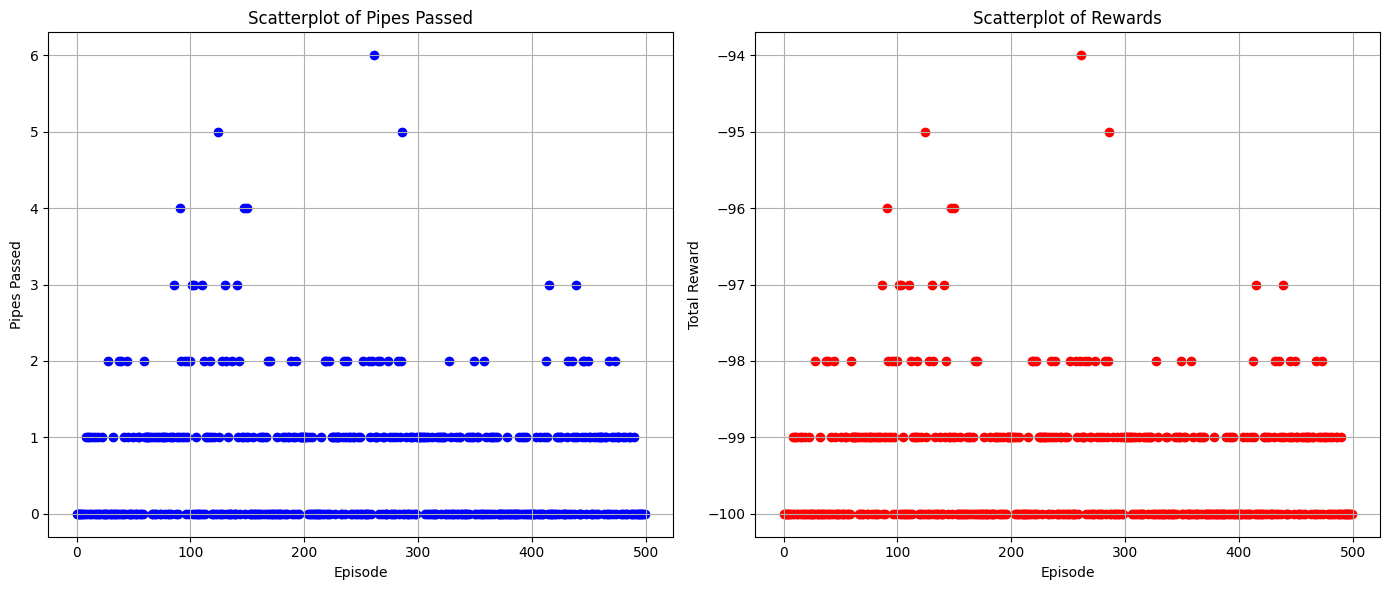

In [8]:
# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Modell anwenden und die Umgebung rendern
state, _ = env.reset()
state = agent.discretize(state)

done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = agent.discretize(next_state)
    env.render()
    state = next_state

env.close()

# DQN Algorithm

## Umgebung

In [10]:
import gym
from gym import spaces
import numpy as np
import pygame
import random

class FlappyBirdEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Seed wird gesetzt
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.pipes = [self._create_pipe()]
        self.passed_pipes = 0
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0
        # Überprüfe, ob der Vogel eine Pipe passiert hat
        if self._passed_pipe():
            reward = 1
            self.passed_pipes += 1  # Zählen der durchflogenen Pipes
        if self.done:
            reward = -100
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}  # Anzahl der durchflogenen Pipes
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_pipe(self):
        gap_start = random.randint(0, self.screen_height - self.pipe_gap)
        top_rect = pygame.Rect(self.screen_width, 0, self.pipe_width, gap_start)
        bottom_rect = pygame.Rect(self.screen_width, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
        return {'top': top_rect, 'bottom': bottom_rect, 'passed': False}
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
            self.pipes.append(self._create_pipe())
            self.score += 1
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False


## Agent

In [11]:
class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)  # Zählen der Pipes aus dem Info-Dictionary
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return total_rewards, pipes_passed

# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
rewards, pipes_passed = agent.train(env, num_episodes=5000)


Episode 1/5000 completed, Reward: -100, Pipes Passed: 1
Episode 2/5000 completed, Reward: -100, Pipes Passed: 0
Episode 3/5000 completed, Reward: -99, Pipes Passed: 1
Episode 4/5000 completed, Reward: -100, Pipes Passed: 0
Episode 5/5000 completed, Reward: -100, Pipes Passed: 0
Episode 6/5000 completed, Reward: -100, Pipes Passed: 0
Episode 7/5000 completed, Reward: -100, Pipes Passed: 0
Episode 8/5000 completed, Reward: -99, Pipes Passed: 1
Episode 9/5000 completed, Reward: -100, Pipes Passed: 0
Episode 10/5000 completed, Reward: -100, Pipes Passed: 0
Episode 11/5000 completed, Reward: -100, Pipes Passed: 0
Episode 12/5000 completed, Reward: -99, Pipes Passed: 1
Episode 13/5000 completed, Reward: -100, Pipes Passed: 0
Episode 14/5000 completed, Reward: -100, Pipes Passed: 0
Episode 15/5000 completed, Reward: -100, Pipes Passed: 0
Episode 16/5000 completed, Reward: -100, Pipes Passed: 0
Episode 17/5000 completed, Reward: -99, Pipes Passed: 1
Episode 18/5000 completed, Reward: -100, Pip

## Plotten der Rewards

In [12]:
df = pd.DataFrame({"Reward": rewards, "Pipes": pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
df.loc[df["Pipes"]==df["Pipes"].max()]

,Reward,Pipes,Index
4487,-92,8,4487


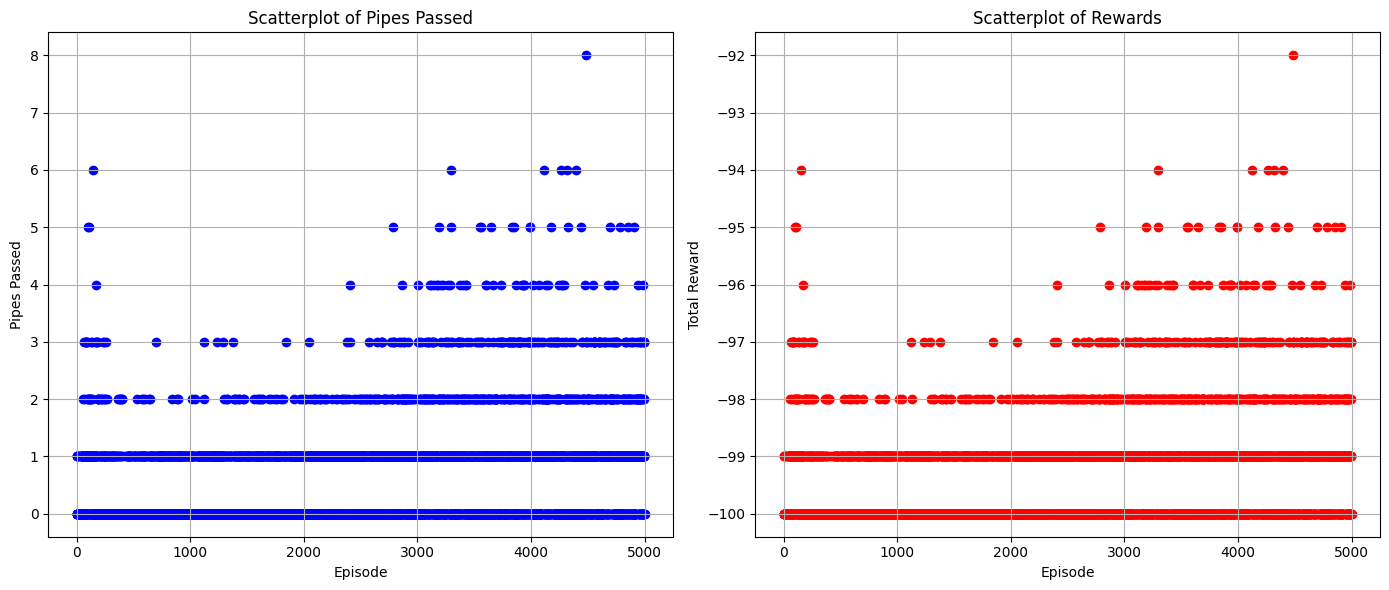

In [13]:
# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

# Soft Actor-Critic (SAC)

In [24]:
import gym
import numpy as np
import pygame
import random
from gym import spaces
from stable_baselines3 import DQN
import matplotlib.pyplot as plt

class FlappyBirdEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 100
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        
    def reset(self):
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.pipes = [self._create_pipe()]
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0
        if self.done:
            reward = -2
        else:
            for pipe in self.pipes:
                if self.bird_x > pipe['top'].right and not pipe.get('passed', False):
                    reward = 1
                    pipe['passed'] = True
                    self.score += 1
        
        observation = self._get_observation()
        info = {'pipe_count': self.score}
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_pipe(self):
        gap_start = random.randint(0, self.screen_height - self.pipe_gap)
        top_rect = pygame.Rect(self.screen_width, 0, self.pipe_width, gap_start)
        bottom_rect = pygame.Rect(self.screen_width, gap_start + self.pipe_gap, self.pipe_width, self.screen_height - gap_start - self.pipe_gap)
        return {'top': top_rect, 'bottom': bottom_rect}
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height:
            self.done = True
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

# Registrierung der Umgebung
gym.envs.registration.register(
    id='FlappyBird-v0',
    entry_point=FlappyBirdEnv,
    max_episode_steps=1000,
)

# Verwendung der benutzerdefinierten Umgebung
env = gym.make('FlappyBird-v0')

# DQN Algorithmus anwenden
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

# Modell speichern
model.save("dqn_flappybird")

# Modell laden und verwenden
model = DQN.load("dqn_flappybird")

# Daten sammeln
episodes = 100
pipe_counts = []
rewards = []

for episode in range(episodes):
    obs, _ = env.reset()
    episode_reward = 0
    episode_pipes = 0
    done = False
    
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        episode_reward += reward
        if reward == 1:  # Wenn eine Pipe passiert wurde
            episode_pipes += 1
    
    pipe_counts.append(episode_pipes)
    rewards.append(episode_reward)

env.close()

# Scatterplot erstellen
plt.scatter(pipe_counts, rewards)
plt.xlabel('Anzahl der Pipes')
plt.ylabel('Reward')
plt.title('Anzahl der Pipes vs. Reward')
plt.show()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [25]:
import gym
import numpy as np
import pygame
import random
from gym import spaces
from stable_baselines3 import DQN
import matplotlib.pyplot as plt

class FlappyBirdEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 100
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        
        self.action_space = spaces.Box(low=np.array([-1.0]), high=np.array([1.0]))  # Kontinuierlicher Aktionsraum
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        
    def reset(self):
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.pipes = [self._create_pipe()]
        return self._get_observation()
    
    def step(self, action):
        # Konvertiere kontinuierliche Aktion in diskrete Aktion
        action = 1 if action > 0 else 0
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0
        if self.done:
            reward = -2
        else:
            for pipe in self.pipes:
                if self.bird_x > pipe['top'].right and not pipe.get('passed', False):
                    reward = 1
                    pipe['passed'] = True
                    self.score += 1
        
        observation = self._get_observation()
        info = {'pipe_count': self.score}
        return observation, reward, self.done, info  # Rückgabe von vier Werten
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_pipe(self):
        gap_start = random.randint(0, self.screen_height - self.pipe_gap)
        top_rect = pygame.Rect(self.screen_width, 0, self.pipe_width, gap_start)
        bottom_rect = pygame.Rect(self.screen_width, gap_start + self.pipe_gap, self.pipe_width, self.screen_height - gap_start - self.pipe_gap)
        return {'top': top_rect, 'bottom': bottom_rect}
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height:
            self.done = True
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

# Registrierung der Umgebung
gym.envs.registration.register(
    id='FlappyBird-v0',
    entry_point=FlappyBirdEnv,
    max_episode_steps=1000,
)

# Verwendung der benutzerdefinierten Umgebung
env = gym.make('FlappyBird-v0')

# DQN Algorithmus anwenden
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

# Modell speichern
model.save("dqn_flappybird")

# Modell laden und verwenden
model = DQN.load("dqn_flappybird")

# Daten sammeln
episodes = 100
pipe_counts = []
rewards = []

for episode in range(episodes):
    obs = env.reset()
    episode_reward = 0
    episode_pipes = 0
    done = False
    
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)  # Vier Rückgabewerte
        episode_reward += reward
        if reward == 1:  # Wenn eine Pipe passiert wurde
            episode_pipes += 1
    
    pipe_counts.append(episode_pipes)
    rewards.append(episode_reward)

env.close()

# Scatterplot erstellen
plt.scatter(pipe_counts, rewards)
plt.xlabel('Anzahl der Pipes')
plt.ylabel('Reward')
plt.title('Anzahl der Pipes vs. Reward')
plt.show()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Box(-1.0, 1.0, (1,), float32) was provided